# 1. Install library(& freeze)

In [1]:
#!pip3 freeze > requirements.txt
!pip3 install -r requirements.txt

  Using cached argon2_cffi-21.3.0-py3-none-any.whl (14 kB)
  Using cached argon2_cffi_bindings-21.2.0-cp38-abi3-macosx_10_9_universal2.whl (53 kB)
  Using cached asttokens-2.0.5-py2.py3-none-any.whl (20 kB)
  Using cached bayesian-optimization-1.2.0.tar.gz (14 kB)
  Preparing metadata (setup.py) ... done
  Using cached beautifulsoup4-4.11.1-py3-none-any.whl (128 kB)
  Using cached bleach-5.0.0-py3-none-any.whl (160 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.1/484.1 kB 3.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Using cached cmake-3.24.1-py2.py3-none-macosx_10_10_universal2.macosx_10_10_x86_64.macosx_11_0_arm64.macosx_11_0_universal2.whl (77.9 MB)
  Using cached Corpora-1.0.tar.gz (5.1 kB)
  Preparing metadata (setup.py) ... done
  Using cached dataclasses-0.6-py3-none-any.whl (14 kB)
  Using cached debugpy-1.6.0-py2.py3-none-any.whl (4.1 MB)
  Using cached defusedxml-0.7.1-py2.py3-none-any.whl (25 kB)
  Using cached entrypoints-0.4-py3-none-any.wh

### Load library

In [2]:
#load library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#load forecastingn tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

#load eval tools
from sklearn.metrics import mean_squared_log_error, mean_absolute_percentage_error #MAPE, WMAPE
from statsmodels.tools.eval_measures import rmse

#ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 2. EDA

### load original dataframe

In [205]:
original_df = pd.read_excel('data.xlsx', index_col='submitted_date', parse_dates=True)

pd.set_option("display.max_rows", original_df.shape[0])
original_df['file_size_per_rec'] = original_df['file_size_gb']/original_df['records']*1000 #into MB
original_df.index = pd.to_datetime(original_df.index)

original_df.head()

,records,file_size_gb,file_size_per_rec
submitted_date,,,
2012-03-01,0.0,0.000874,inf
2012-04-01,68570206.0,57843.503303,0.843566
2012-05-01,70764937.0,53755.010719,0.759628
2012-06-01,70276934.0,51089.201694,0.726970
2012-07-01,72163073.0,57436.068959,0.795920


In [179]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 131 entries, 2012-03-01 to 2023-01-01
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   records            130 non-null    float64
 1   file_size_gb       130 non-null    float64
 2   file_size_per_rec  130 non-null    float64
dtypes: float64(3)
memory usage: 4.1 KB


In [175]:
original_df.isnull().sum().sort_values(ascending = False)

records              1
file_size_gb         1
file_size_per_rec    1
dtype: int64

In [106]:
original_df.describe()

,records,file_size_gb
count,1.300000e+02,130.000000
mean,1.191958e+08,118546.352699
std,5.785218e+07,51286.528102
min,0.000000e+00,0.000874
25%,7.665259e+07,67904.114447
50%,1.139575e+08,117289.622867
75%,1.410827e+08,164550.493823
max,5.498661e+08,210865.107593


##### Graph - Whole 10 years

0 records
1 file_size_gb
2 file_size_per_rec


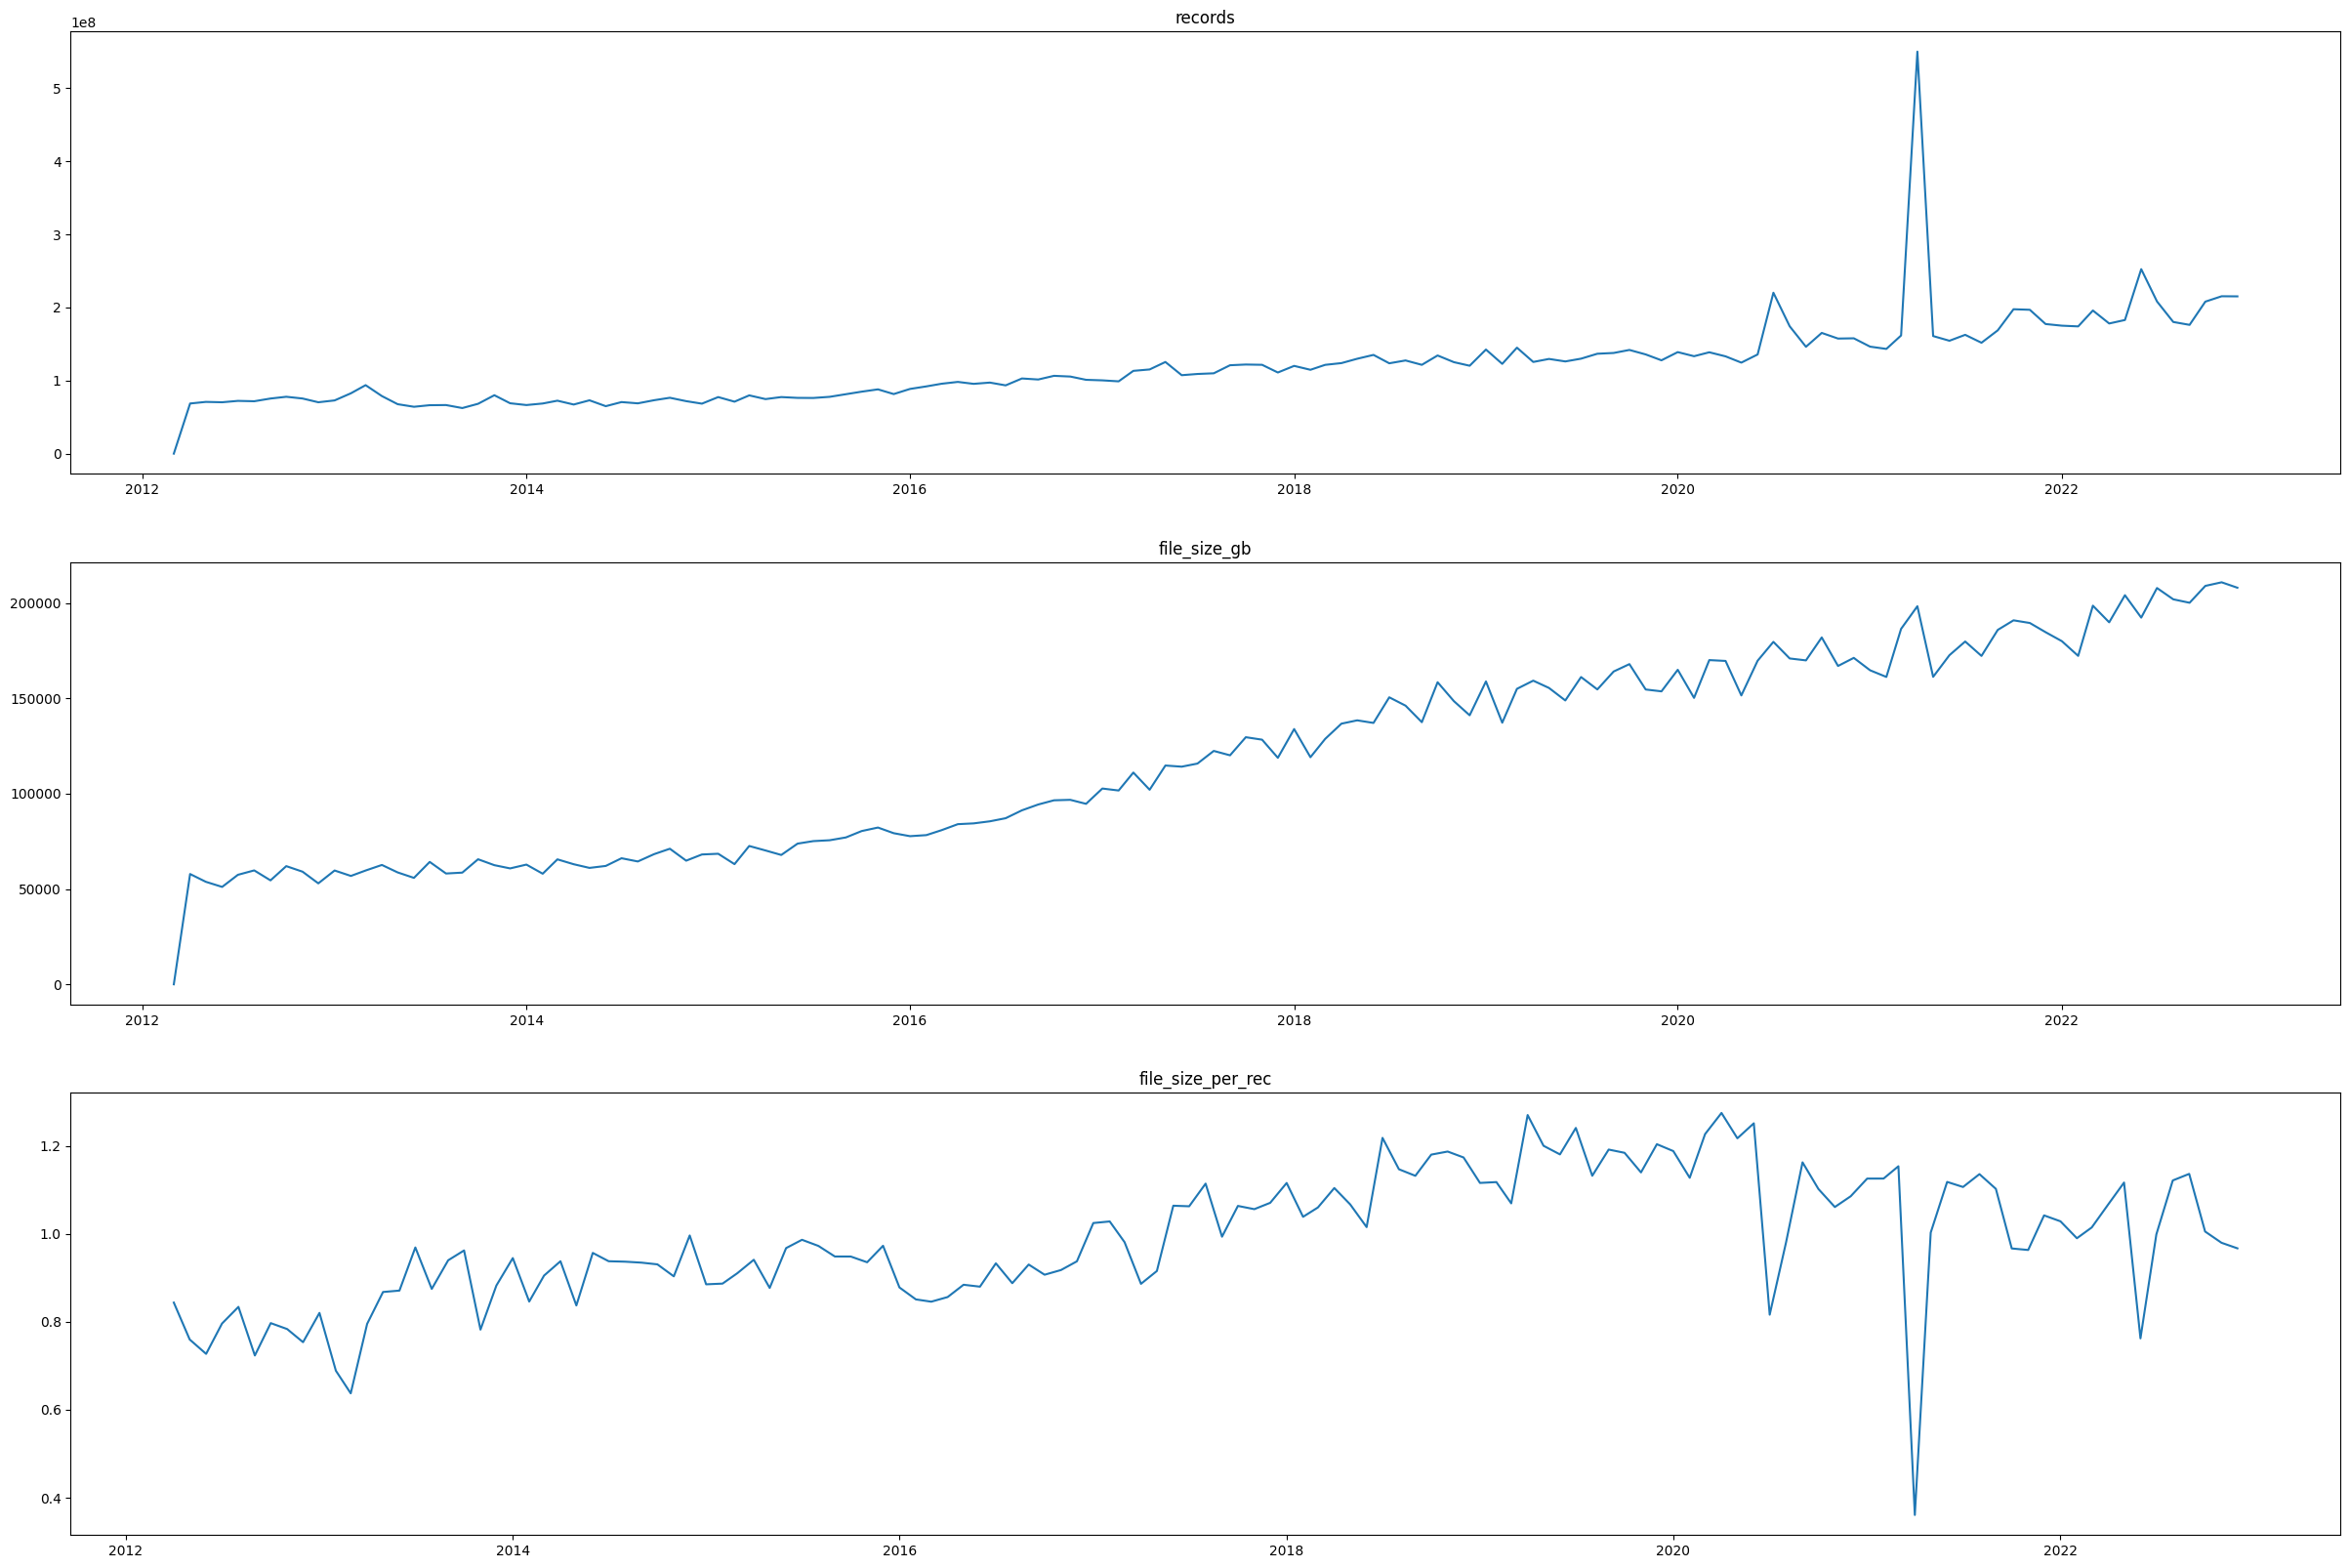

In [168]:
def viz(df):
    plt.figure(figsize=(30,20))
    cols = df.columns
    l = len(cols)
    for i,c in enumerate(cols):
        print(i,c)
        plt.subplot(l,1,i+1)
        #plt.plot(df.submitted_date, df[c])
        plt.plot(df[c])
        plt.title(c)

    plt.show()

viz(original_df)

##### Graph - After Jun 2020

0 records
1 file_size_gb
2 file_size_per_rec


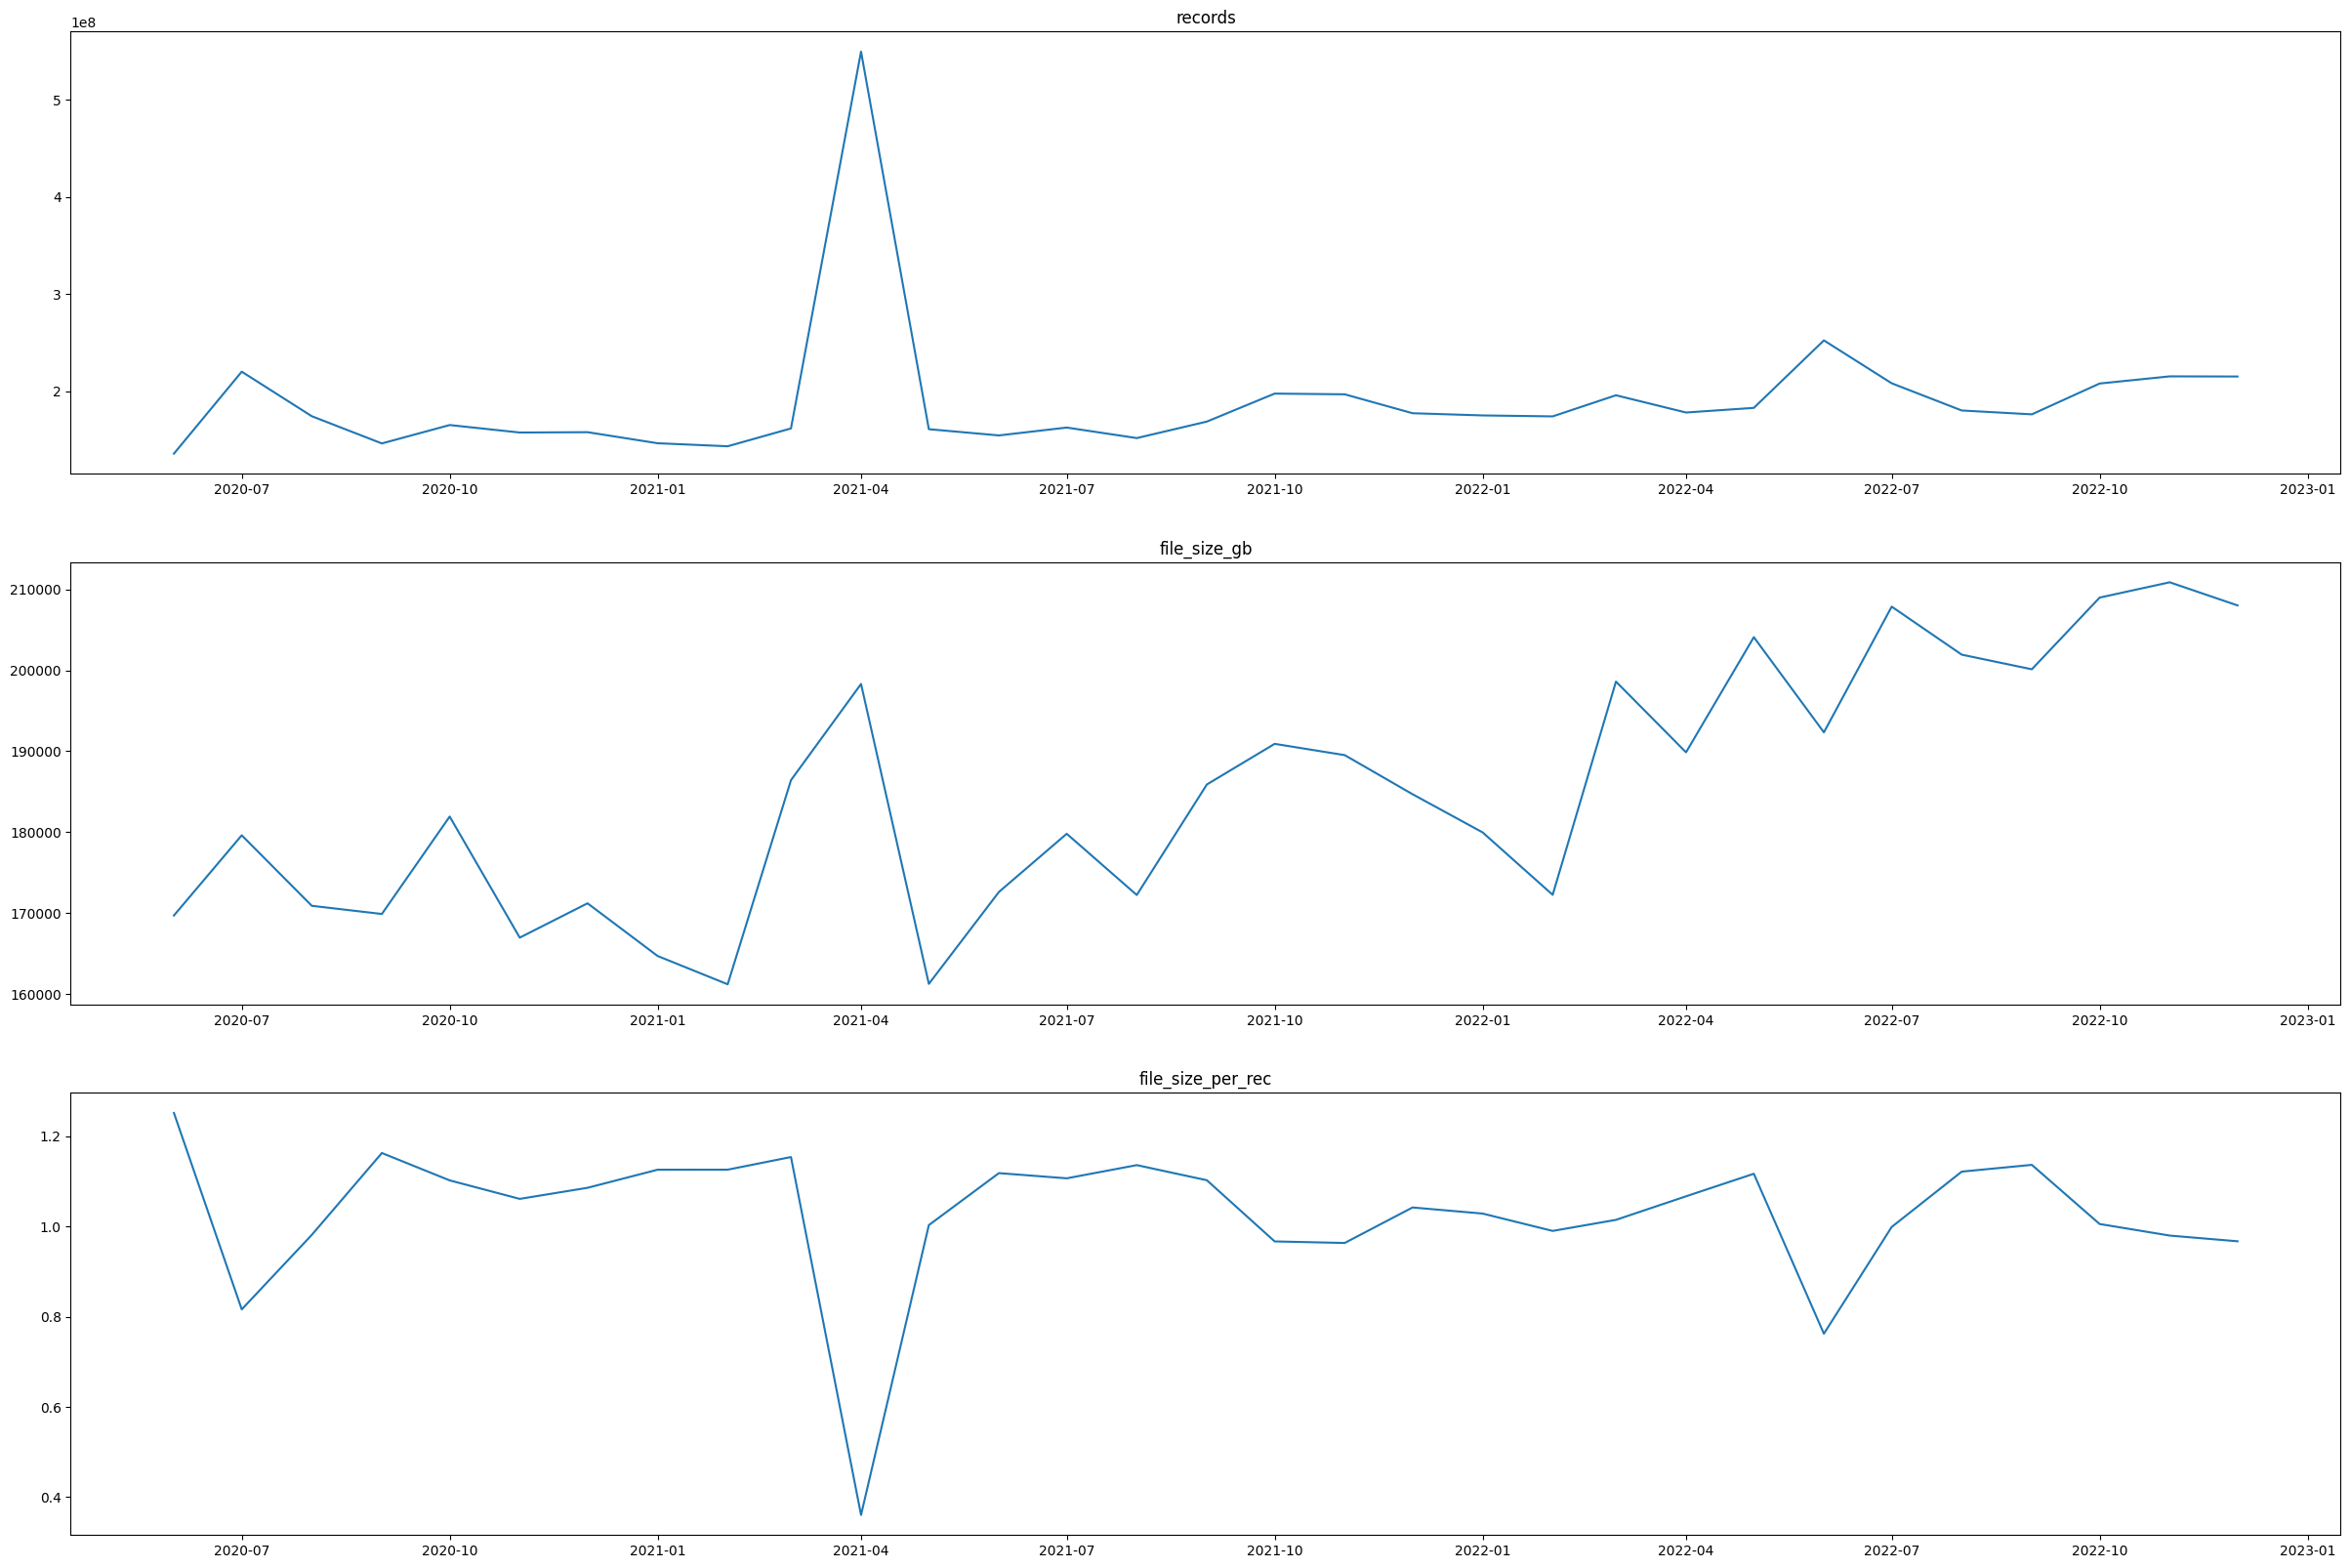

In [177]:
tempdf = original_df['2020-06':]
viz(tempdf)

In [215]:
tempdf

,records,file_size_gb,file_size_per_rec
submitted_date,,,
2020-06-01,135640104.0,169716.569124,1.251227
2020-07-01,220099737.0,179618.550297,0.816078
2020-08-01,174190352.0,170909.299443,0.981164
2020-09-01,146153884.0,169901.356074,1.162483
2020-10-01,165114662.0,181930.844124,1.101845
2020-11-01,157395317.0,166978.232563,1.060884
2020-12-01,157743014.0,171218.638941,1.085428
2021-01-01,146343183.0,164712.781319,1.125524
2021-02-01,143228431.0,161215.277410,1.125582


In [227]:
temp_size = tempdf[['file_size_gb']]
#temp_size
print((temp_size.loc['2021-04-01'] - temp_size.loc['2021-03-01'])/temp_size.loc['2021-03-01']*100)

file_size_gb    6.371784
dtype: float64


In [225]:
print((temp_size.loc['2021-04-01'] - temp_size.loc['2021-03-01']))

file_size_gb    11878.696738
dtype: float64


In [226]:
temp_rec = tempdf[['records']]
#temp_rec
print((temp_rec.loc['2021-04-01'] - temp_rec.loc['2021-03-01'])/temp_rec.loc['2021-03-01']*100)

records    240.244769
dtype: float64


In [230]:
temp_size_per_rec = tempdf[['file_size_per_rec']]
print((temp_size_per_rec.loc['2021-04-01'] - temp_size_per_rec.loc['2021-03-01'])/temp_size_per_rec.loc['2021-03-01']*100)

file_size_per_rec   -68.736688
dtype: float64


In [233]:
#What 10 months have the highest file size loaded?
df.sort_values(by='file_size_gb', ascending=False).head(10)

,file_size_gb,Month
submitted_date,,
2022-11-01,210865.107593,11
2022-10-01,208974.574449,10
2022-12-01,208009.046105,12
2022-07-01,207857.828844,7
2022-05-01,204087.179591,5
2022-08-01,201925.201299,8
2022-09-01,200120.592662,9
2022-03-01,198599.452134,3
2021-04-01,198305.233768,4


<Axes: xlabel='submitted_date'>

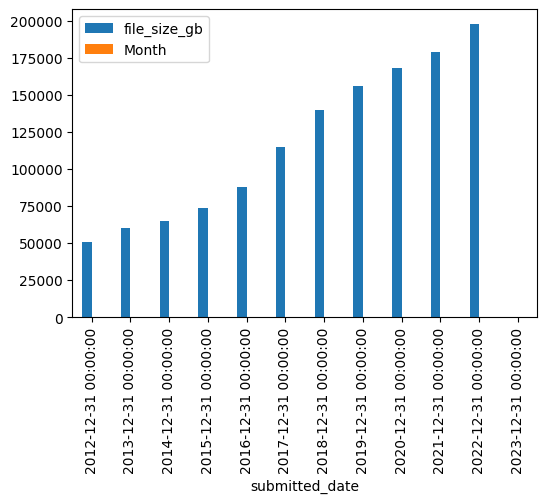

In [237]:
#Bar plot describing the avg. value in filesize per year
df.resample('Y').mean().plot.bar(figsize=(6,4))

In [241]:
yearly = df.resample('Y').mean()
yearly_shift = yearly.shift(1)
chg = yearly - yearly_shift
chg['file_size_gb'].idxmax()

Timestamp('2017-12-31 00:00:00', freq='A-DEC')

##### Questions for EDA
1. Quarterly/monthly features(patterns) for 10-years
2. The change of average upload file size per record
3. What kind of small datasets 

##### Rolling quartly, yearly for MA(Moving Average)

MA -> EWMA necessary

In [256]:
df['mean_yearly'] = df['file_size_gb'].rolling(window=12).mean()
df.head()

,records,file_size_gb,file_size_per_rec,mean_yearly
submitted_date,,,,
2012-03-01,0.0,0.000874,inf,NaN
2012-04-01,68570206.0,57843.503303,0.843566,NaN
2012-05-01,70764937.0,53755.010719,0.759628,NaN
2012-06-01,70276934.0,51089.201694,0.726970,NaN
2012-07-01,72163073.0,57436.068959,0.795920,NaN


In [257]:
#df[['file_size_gb', 'mean_yearly']].plot(figsize=(10,6))

##### monthly boxplot

In [258]:
df = pd.read_excel('data.xlsx', index_col='submitted_date', parse_dates=True)
df.index = pd.to_datetime(df.index)
df = df[['file_size_gb']]
df['Month'] = df.index.month
#df['Month'] = df.index.strftime('%B')

df.head()

,file_size_gb,Month
submitted_date,,
2012-03-01,0.000874,3
2012-04-01,57843.503303,4
2012-05-01,53755.010719,5
2012-06-01,51089.201694,6
2012-07-01,57436.068959,7


<Axes: title={'center': 'file_size_gb'}, xlabel='[Month]'>

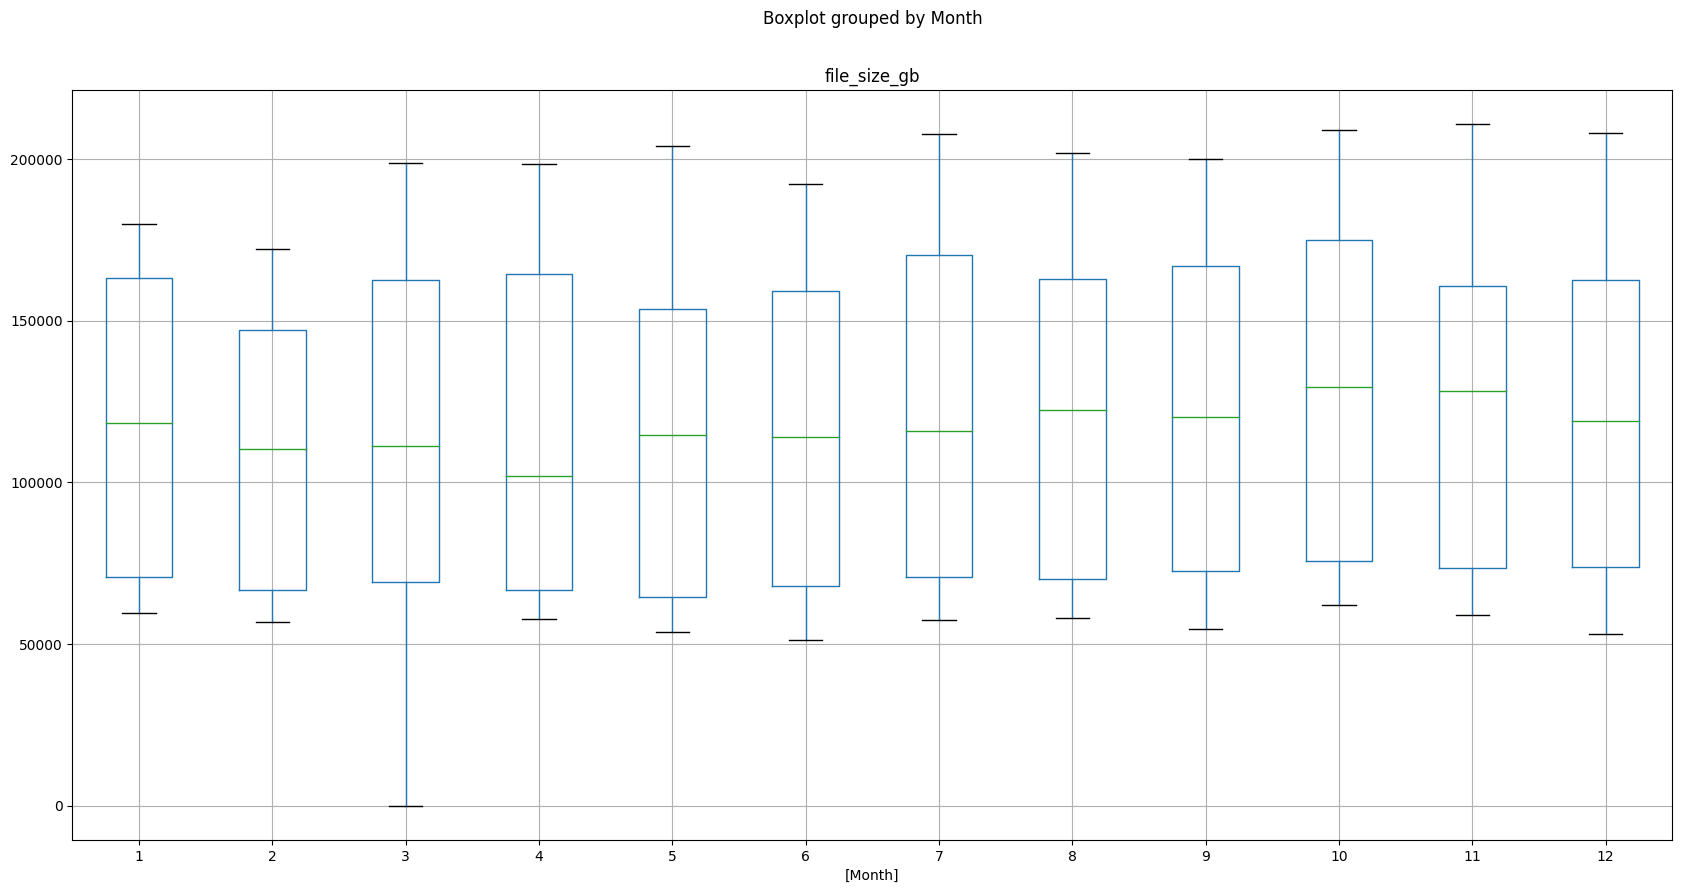

In [259]:
#Boxplot groups by the Month 
df.boxplot(by='Month', figsize=(20,10))

### Insights from EDA
1. What was the percent increase in records, and file size from Mar 2021 to Apr 2021?

April 2021 records up +240.24% from last month, On the other hand, the uploaded file size increased by +6.37%(11,878.69GB), which is very small compared to the # of the increased records

2. How did the size per file (MB) change compared to last month in April 2021, when the number of uploads soared, ?

Average file size per record decreased by -68.73% in April(0.36MB) compared to March(1.15MB) 2021. It seems necessary to manually check which small files have been uploaded in bulk by user or file type.

3. Which year the biggest increase in mean from the previous year's mean?

Btwn 2016 and 2017

4. Change in the amount of upload file size per month?

Upload file size increased in the second half of the year than in the first half

# 3. TSA(Time Series Analysis)

##### *) Load data newly

In [224]:
df = pd.read_excel('data.xlsx', index_col='submitted_date', parse_dates=True)
df.index = pd.to_datetime(df.index)
df.index.names = ['Date']
print(df.head(), df.tail())

               records  file_size_gb
Date                                
2012-03-01         0.0      0.000874
2012-04-01  68570206.0  57843.503303
2012-05-01  70764937.0  53755.010719
2012-06-01  70276934.0  51089.201694
2012-07-01  72163073.0  57436.068959                 records   file_size_gb
Date                                  
2022-09-01  176125051.0  200120.592662
2022-10-01  207894540.0  208974.574449
2022-11-01  215259474.0  210865.107593
2022-12-01  215117324.0  208009.046105
2023-01-01          NaN            NaN


In [225]:
#remove missing values - the first one & the last one to be predicted
df = df.iloc[1:-1]

# 3-1) Smoothing

##### SMA(Simple Moving Avg.) 12-month

<Axes: xlabel='Date'>

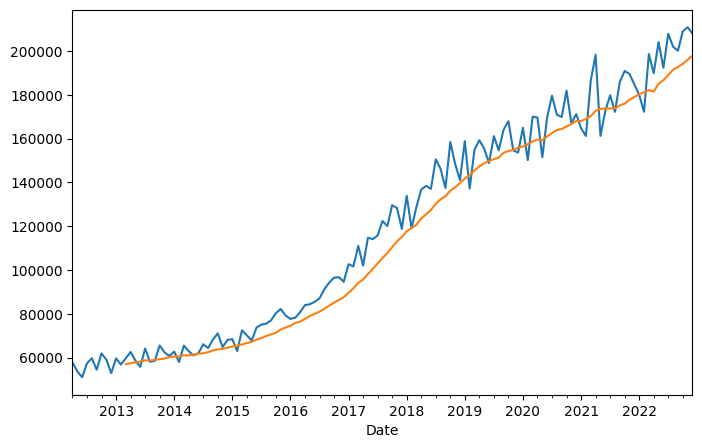

In [116]:
df['file_size_gb'].plot(figsize=(8,5))
df.rolling(window=12).mean()['file_size_gb'].plot() #Yearly(12M) mean

<Axes: xlabel='Date'>

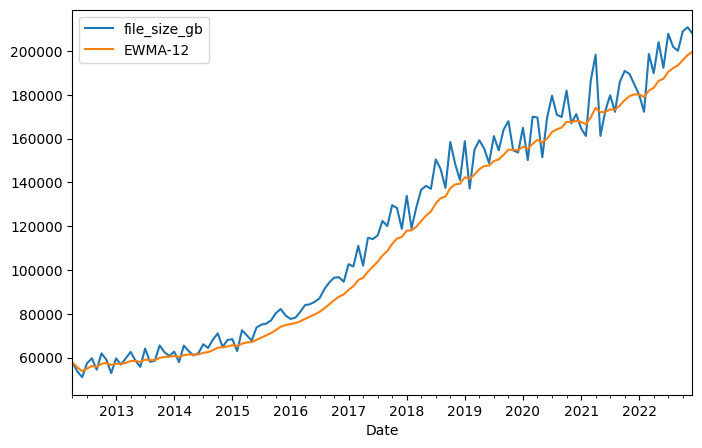

In [117]:
#12months
df['EWMA-12'] = df['file_size_gb'].ewm(span=12).mean()
df[['file_size_gb', 'EWMA-12']].plot(figsize=(8,5))

##### SimpleExpSmoothing
- EWMA(Exponentially Weighted) w/ a span 12, statsmodels.SimpleExpSmoothing

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 128 entries, 2012-04-01 to 2022-11-01
Freq: MS
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   file_size_gb  128 non-null    float64
 1   DES12_mul     128 non-null    float64
dtypes: float64(2)
memory usage: 3.0 KB


##### *) Assign a frequency of 'MS' to the DatetimeIndex

In [226]:
#set datatime freq. MS(Each data starts the 1st day in every month)
df.index.freq = 'MS'
df.index

DatetimeIndex(['2012-04-01', '2012-05-01', '2012-06-01', '2012-07-01',
               '2012-08-01', '2012-09-01', '2012-10-01', '2012-11-01',
               '2012-12-01', '2013-01-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='Date', length=129, freq='MS')

In [227]:
print(df.head(), df.tail())

               records  file_size_gb
Date                                
2012-04-01  68570206.0  57843.503303
2012-05-01  70764937.0  53755.010719
2012-06-01  70276934.0  51089.201694
2012-07-01  72163073.0  57436.068959
2012-08-01  71651811.0  59746.605215                 records   file_size_gb
Date                                  
2022-08-01  180081963.0  201925.201299
2022-09-01  176125051.0  200120.592662
2022-10-01  207894540.0  208974.574449
2022-11-01  215259474.0  210865.107593
2022-12-01  215117324.0  208009.046105


In [120]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
span=12
alpha = 2/(span+1)
df['EWMA12'] = df['file_size_gb'].ewm(alpha=alpha, adjust=False).mean()
df.head(10)

,records,file_size_gb,EWMA-12,EWMA12
Date,,,,
2012-04-01,68570206.0,57843.503303,57843.503303,57843.503303
2012-05-01,70764937.0,53755.010719,55628.903153,57214.504444
2012-06-01,70276934.0,51089.201694,53857.056625,56272.150175
2012-07-01,72163073.0,57436.068959,54986.810950,56451.214603
2012-08-01,71651811.0,59746.605215,56280.030040,56958.197774
2012-09-01,75368726.0,54513.445203,55850.656985,56582.081994
2012-10-01,77782176.0,61984.471254,57219.396179,57413.218803
2012-11-01,75404830.0,59072.326168,57606.074108,57668.466090
2012-12-01,70265920.0,52947.732420,56684.488318,56942.199372


In [121]:
model = SimpleExpSmoothing(df['file_size_gb']).fit(smoothing_level=alpha, optimized=False)
model

In [122]:
model.fittedvalues 

Date
2012-04-01     57843.503303
2012-05-01     57843.503303
2012-06-01     57214.504444
2012-07-01     56272.150175
2012-08-01     56451.214603
2012-09-01     56958.197774
2012-10-01     56582.081994
2012-11-01     57413.218803
2012-12-01     57668.466090
2013-01-01     56942.199372
2013-02-01     57365.270560
2013-03-01     57284.584729
2013-04-01     57654.315390
2013-05-01     58415.539792
2013-06-01     58457.109689
2013-07-01     58051.627643
2013-08-01     58996.531699
2013-09-01     58860.910407
2013-10-01     58818.492539
2013-11-01     59860.412062
2013-12-01     60264.352161
2014-01-01     60346.042301
2014-02-01     60722.141587
2014-03-01     60304.529956
2014-04-01     61109.327295
2014-05-01     61397.170166
2014-06-01     61345.059493
2014-07-01     61459.316390
2014-08-01     62176.954438
2014-09-01     62523.351544
2014-10-01     63407.467402
2014-11-01     64591.783076
2014-12-01     64631.207839
2015-01-01     65164.570411
2015-02-01     65673.606486
2015-03-01     

In [123]:
model.fittedvalues.shift(-1) #한칸씩 밀어주기

Date
2012-04-01     57843.503303
2012-05-01     57214.504444
2012-06-01     56272.150175
2012-07-01     56451.214603
2012-08-01     56958.197774
2012-09-01     56582.081994
2012-10-01     57413.218803
2012-11-01     57668.466090
2012-12-01     56942.199372
2013-01-01     57365.270560
2013-02-01     57284.584729
2013-03-01     57654.315390
2013-04-01     58415.539792
2013-05-01     58457.109689
2013-06-01     58051.627643
2013-07-01     58996.531699
2013-08-01     58860.910407
2013-09-01     58818.492539
2013-10-01     59860.412062
2013-11-01     60264.352161
2013-12-01     60346.042301
2014-01-01     60722.141587
2014-02-01     60304.529956
2014-03-01     61109.327295
2014-04-01     61397.170166
2014-05-01     61345.059493
2014-06-01     61459.316390
2014-07-01     62176.954438
2014-08-01     62523.351544
2014-09-01     63407.467402
2014-10-01     64591.783076
2014-11-01     64631.207839
2014-12-01     65164.570411
2015-01-01     65673.606486
2015-02-01     65266.865758
2015-03-01     

In [124]:
#SimpleExpSmoothing
df['SES12'] = model.fittedvalues.shift(-1)
df.head(10)

#단일지수평활법이 EWMA와 완전히 동일. EWMA12 == SES12

,records,file_size_gb,EWMA-12,EWMA12,SES12
Date,,,,,
2012-04-01,68570206.0,57843.503303,57843.503303,57843.503303,57843.503303
2012-05-01,70764937.0,53755.010719,55628.903153,57214.504444,57214.504444
2012-06-01,70276934.0,51089.201694,53857.056625,56272.150175,56272.150175
2012-07-01,72163073.0,57436.068959,54986.810950,56451.214603,56451.214603
2012-08-01,71651811.0,59746.605215,56280.030040,56958.197774,56958.197774
2012-09-01,75368726.0,54513.445203,55850.656985,56582.081994,56582.081994
2012-10-01,77782176.0,61984.471254,57219.396179,57413.218803,57413.218803
2012-11-01,75404830.0,59072.326168,57606.074108,57668.466090,57668.466090
2012-12-01,70265920.0,52947.732420,56684.488318,56942.199372,56942.199372


##### DoubleExponentialSmoothing w/ Winter-Holters

<Axes: xlabel='Date'>

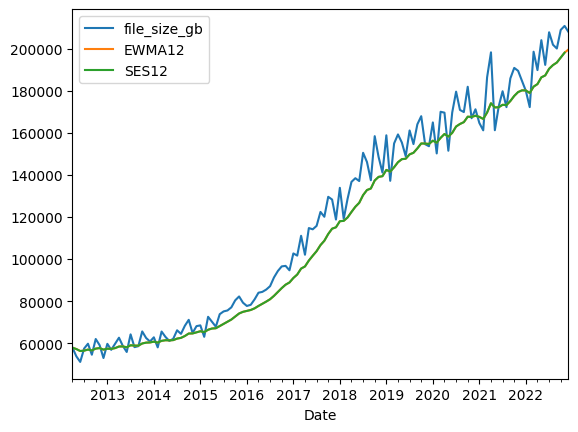

In [125]:
df[['file_size_gb', 'EWMA12', 'SES12']].plot()

In [126]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
df['DES12'] = ExponentialSmoothing(df['file_size_gb'], trend='add').fit().fittedvalues.shift(-1)
df.head()

,records,file_size_gb,EWMA-12,EWMA12,SES12,DES12
Date,,,,,,
2012-04-01,68570206.0,57843.503303,57843.503303,57843.503303,57843.503303,56077.569292
2012-05-01,70764937.0,53755.010719,55628.903153,57214.504444,57214.504444,56051.770372
2012-06-01,70276934.0,51089.201694,53857.056625,56272.150175,56272.150175,55433.751500
2012-07-01,72163073.0,57436.068959,54986.810950,56451.214603,56451.214603,56057.630245
2012-08-01,71651811.0,59746.605215,56280.030040,56958.197774,56958.197774,57074.852144


<Axes: xlabel='Date'>

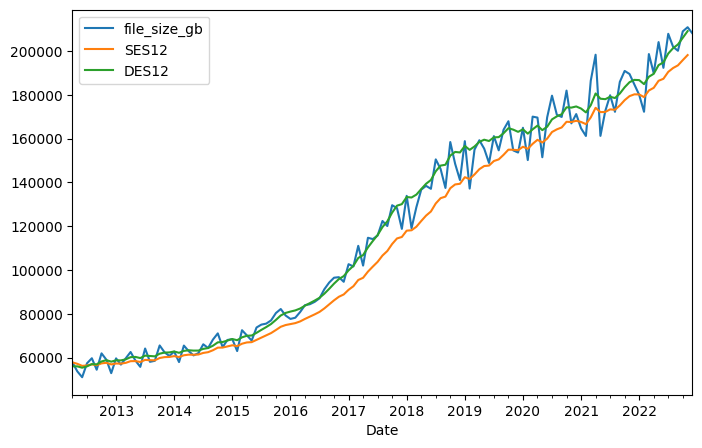

In [127]:
df[['file_size_gb','SES12', 'DES12']].plot(figsize=(8,5))

<Axes: xlabel='Date'>

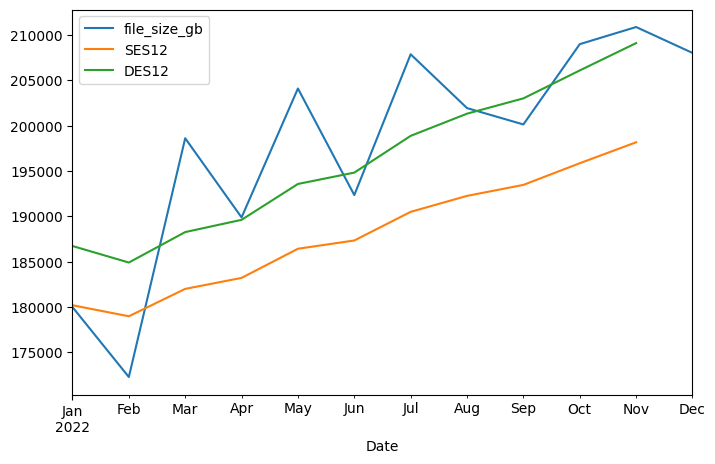

In [128]:
df[['file_size_gb','SES12', 'DES12']].iloc[-12:].plot(figsize=(8,5)) #the recent year(2022)

##### TripleExponentialSmoothing w/ Winter-Holters

In [129]:
df['TES12'] = ExponentialSmoothing(df['file_size_gb'], trend='add',seasonal='add', seasonal_periods=12 ).fit().fittedvalues.shift(-1)
df.head()

,records,file_size_gb,EWMA-12,EWMA12,SES12,DES12,TES12
Date,,,,,,,
2012-04-01,68570206.0,57843.503303,57843.503303,57843.503303,57843.503303,56077.569292,55519.593240
2012-05-01,70764937.0,53755.010719,55628.903153,57214.504444,57214.504444,56051.770372,55934.908239
2012-06-01,70276934.0,51089.201694,53857.056625,56272.150175,56272.150175,55433.751500,58111.522234
2012-07-01,72163073.0,57436.068959,54986.810950,56451.214603,56451.214603,56057.630245,56357.420964
2012-08-01,71651811.0,59746.605215,56280.030040,56958.197774,56958.197774,57074.852144,58374.706978


<Axes: xlabel='Date'>

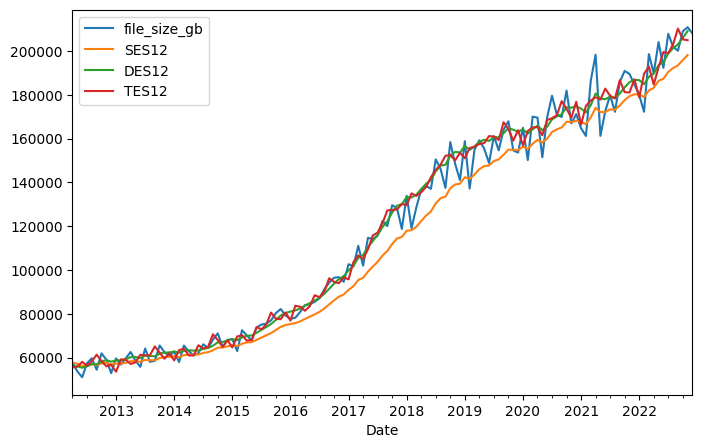

In [130]:
df[['file_size_gb','SES12', 'DES12', 'TES12']].plot(figsize=(8,5)) 

<Axes: xlabel='Date'>

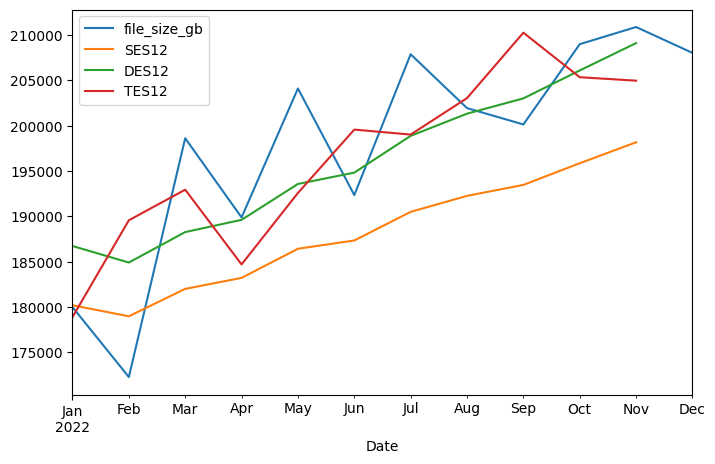

In [131]:
df[['file_size_gb','SES12', 'DES12', 'TES12']].iloc[-12:].plot(figsize=(8,5)) #the recent year(2022)

In [132]:
df.columns

Index(['records', 'file_size_gb', 'EWMA-12', 'EWMA12', 'SES12', 'DES12',
       'TES12'],
      dtype='object')

In [133]:
df = df[['file_size_gb', 'DES12']]
df.head()

,file_size_gb,DES12
Date,,
2012-04-01,57843.503303,56077.569292
2012-05-01,53755.010719,56051.770372
2012-06-01,51089.201694,55433.751500
2012-07-01,57436.068959,56057.630245
2012-08-01,59746.605215,57074.852144


<Axes: xlabel='Date'>

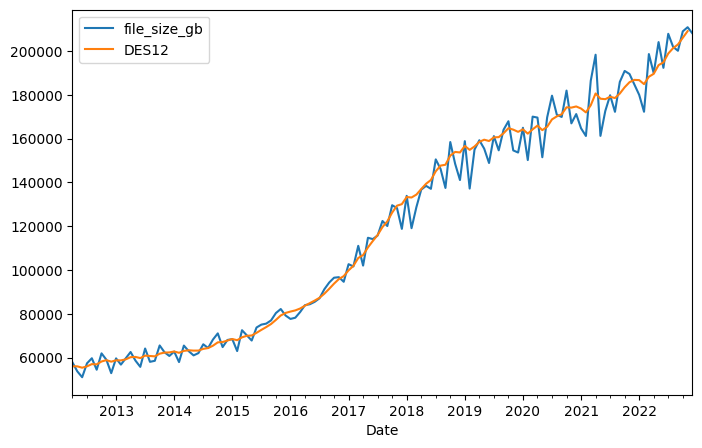

In [134]:
df.plot(figsize=(8,5))

##### *) Multiplicative w/ DES

In [228]:
df['DES12_mul'] = ExponentialSmoothing(df['file_size_gb'], trend='mul',seasonal='mul', seasonal_periods=12 ).fit().fittedvalues#.shift(-1)
print(df.head(), df.tail())

               records  file_size_gb     DES12_mul
Date                                              
2012-04-01  68570206.0  57843.503303  57922.180154
2012-05-01  70764937.0  53755.010719  55858.405763
2012-06-01  70276934.0  51089.201694  55898.739600
2012-07-01  72163073.0  57436.068959  57597.438492
2012-08-01  71651811.0  59746.605215  55893.418250                 records   file_size_gb      DES12_mul
Date                                                 
2022-08-01  180081963.0  201925.201299  200468.755358
2022-09-01  176125051.0  200120.592662  206756.728054
2022-10-01  207894540.0  208974.574449  220047.950590
2022-11-01  215259474.0  210865.107593  208907.318959
2022-12-01  215117324.0  208009.046105  202827.541532


In [194]:
df = df[:-1]
print(df.head(), df.tail())

            file_size_gb     DES12_mul
Date                                  
2012-04-01  57843.503303  55858.405763
2012-05-01  53755.010719  55898.739600
2012-06-01  51089.201694  57597.438492
2012-07-01  57436.068959  55893.418250
2012-08-01  59746.605215  57910.955356              file_size_gb      DES12_mul
Date                                    
2022-06-01  192333.388544  203130.948487
2022-07-01  207857.828844  200468.755358
2022-08-01  201925.201299  206756.728054
2022-09-01  200120.592662  220047.950590
2022-10-01  208974.574449  208907.318959


<Axes: xlabel='Date'>

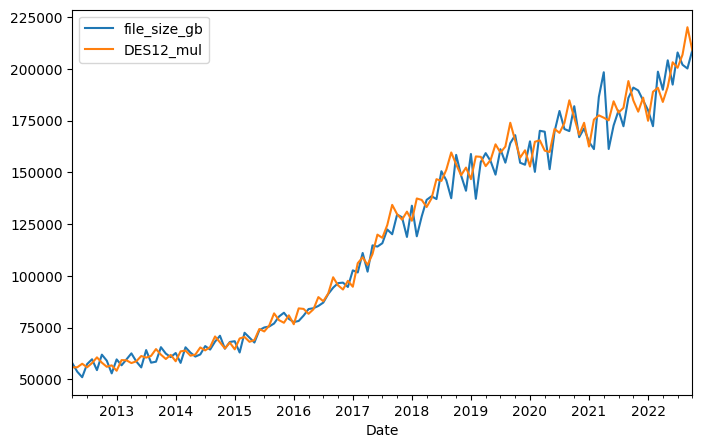

In [195]:
df.plot(figsize=(8,5))

<Axes: xlabel='Date'>

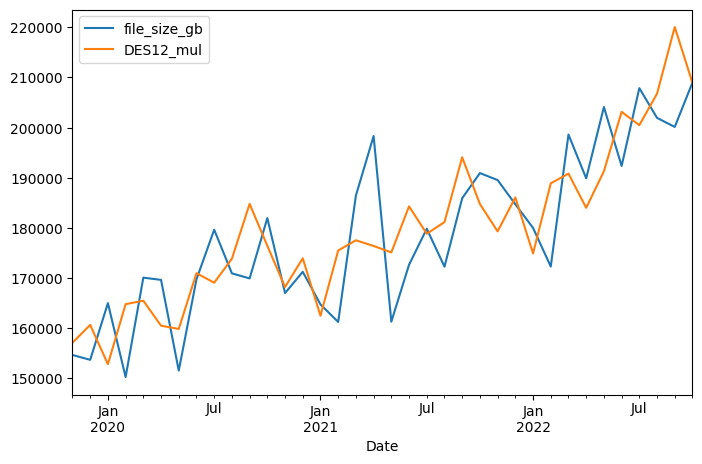

In [196]:
df.iloc[-36:].plot(figsize=(8,5)) #the recent 3 yrs, 2020~2022

In [197]:
# mul > add (The mul model includes seasonality more than additive model)
df = df[['file_size_gb', 'DES12_mul']]
df.head()

,file_size_gb,DES12_mul
Date,,
2012-04-01,57843.503303,55858.405763
2012-05-01,53755.010719,55898.739600
2012-06-01,51089.201694,57597.438492
2012-07-01,57436.068959,55893.418250
2012-08-01,59746.605215,57910.955356


<Axes: xlabel='Date'>

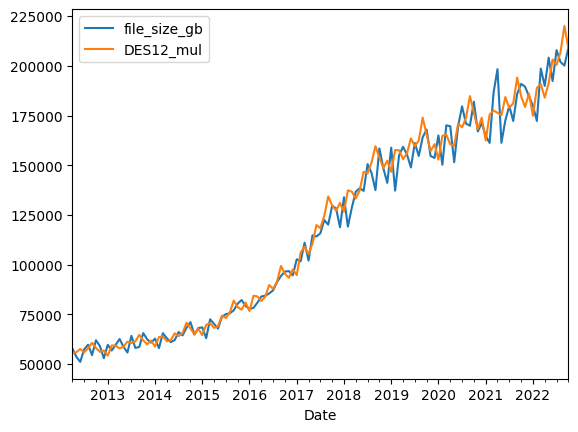

In [198]:
df.plot()

# 3-2) ETC Decomposition 
- additive model(linear increasing trend, regular seasonality)
- multiplicative model(exponential increasing trend, non-linear changes. EX) stocks, NASDAQ)

In [229]:
df = df[['file_size_gb', 'DES12_mul']]
print(df.head(), df.tail())

            file_size_gb     DES12_mul
Date                                  
2012-04-01  57843.503303  57922.180154
2012-05-01  53755.010719  55858.405763
2012-06-01  51089.201694  55898.739600
2012-07-01  57436.068959  57597.438492
2012-08-01  59746.605215  55893.418250              file_size_gb      DES12_mul
Date                                    
2022-08-01  201925.201299  200468.755358
2022-09-01  200120.592662  206756.728054
2022-10-01  208974.574449  220047.950590
2022-11-01  210865.107593  208907.318959
2022-12-01  208009.046105  202827.541532


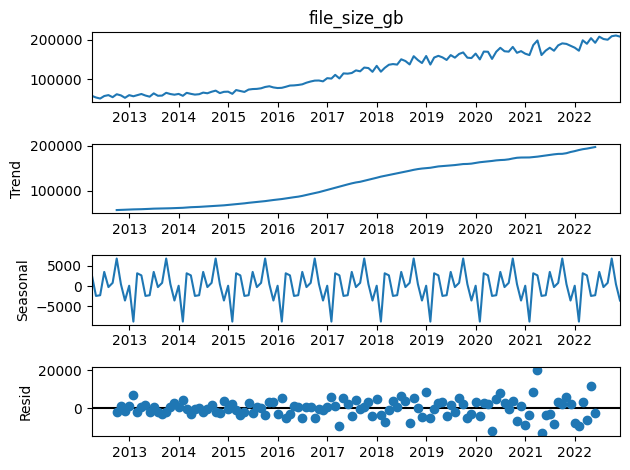

In [230]:
result = seasonal_decompose(df['file_size_gb'], model='add')
result.plot();

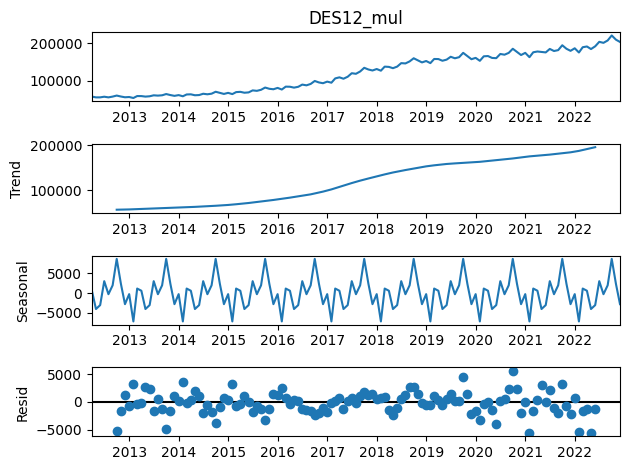

In [231]:
result = seasonal_decompose(df['DES12_mul'], model='add')
result.plot();

- Checking the upward trend and the clear seasonal factor pattern, and increasing residuals(random) since 2018

# 3-3) auto_arima() to find orders(p,d,q)

In [232]:
# w/original data
auto_arima(df[['file_size_gb']], seasonal=True, m=12).summary()# (2, 1, 0)x(0, 0, [1, 2], 12)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  129
Model:             SARIMAX(2, 1, 0)x(0, 0, [1, 2], 12)   Log Likelihood               -1313.949
Date:                                 Thu, 16 Mar 2023   AIC                           2639.898
Time:                                         14:55:41   BIC                           2657.010
Sample:                                     04-01-2012   HQIC                          2646.851
                                          - 12-01-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2725.4680    971.148      2.806      0.005     822.053    4628.883
ar.L1         -0.5964      0.055    -10.795      0.000      -0.705      -0.488
ar.L2         -0.3285      0.059     -5.596      0.000      -0.444      -0.213
ma.S.L12       0.2669      0.072      3.704      0.000       0.126       0.408
ma.S.L24       0.1473      0.106      1.395      0.163      -0.060       0.354
sigma2      4.921e+07      0.030   1.64e+09      0.000    4.92e+07    4.92e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.22   Jarque-Bera (JB):                 8.98
Prob(Q):                              0.27   Prob(JB):                         0.01
Heteroskedasticity (H):               3.41   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+25. Standard errors may be unstable.
"""

In [233]:
# w/ DES data
auto_arima(df[['DES12_mul']], seasonal=True, m=12).summary()# (0, 1, 0)x(0, 1, 0, 12)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  129
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -1042.421
Date:                            Thu, 16 Mar 2023   AIC                           2086.842
Time:                                    14:55:43   BIC                           2089.595
Sample:                                04-01-2012   HQIC                          2087.959
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.704e+06   3.15e+05     11.771      0.000    3.09e+06    4.32e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):                35.40
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               8.19   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 3-4) Split train/test & training the candidate models

In [239]:
#Set the recent one year(2022) for testing! 
train = df.iloc[:len(df)-6]
test = df.iloc[len(df)-6:]
print(len(train), len(test))

123 6


In [240]:
print(train.head(), test.head())

            file_size_gb     DES12_mul
Date                                  
2012-04-01  57843.503303  57922.180154
2012-05-01  53755.010719  55858.405763
2012-06-01  51089.201694  55898.739600
2012-07-01  57436.068959  57597.438492
2012-08-01  59746.605215  55893.418250              file_size_gb      DES12_mul
Date                                    
2022-07-01  207857.828844  203130.948487
2022-08-01  201925.201299  200468.755358
2022-09-01  200120.592662  206756.728054
2022-10-01  208974.574449  220047.950590
2022-11-01  210865.107593  208907.318959


In [241]:
print(train.tail(), test.tail())

             file_size_gb      DES12_mul
Date                                    
2022-02-01  172266.099968  174876.506687
2022-03-01  198599.452134  188865.113467
2022-04-01  189866.486698  190808.270385
2022-05-01  204087.179591  183980.632818
2022-06-01  192333.388544  191272.752045              file_size_gb      DES12_mul
Date                                    
2022-08-01  201925.201299  200468.755358
2022-09-01  200120.592662  206756.728054
2022-10-01  208974.574449  220047.950590
2022-11-01  210865.107593  208907.318959
2022-12-01  208009.046105  202827.541532


In [242]:
#candidate 1) SARIMA(2,1,0)x(0,0,1,12) model for training
model1 = SARIMAX(train['file_size_gb'], order=(2,1,0), seasonal_order=(0,0,1,12))
results1 = model1.fit()
results1.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03208D+01    |proj g|=  1.66598D-01

At iterate    5    f=  1.02357D+01    |proj g|=  1.56862D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   8.677D-06   1.024D+01
  F =   10.235708317088141     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         file_size_gb   No. Observations:                  123
Model:             SARIMAX(2, 1, 0)x(0, 0, [1], 12)   Log Likelihood               -1258.992
Date:                              Thu, 16 Mar 2023   AIC                           2525.984
Time:                                      14:57:39   BIC                           2537.200
Sample:                                  04-01-2012   HQIC                          2530.540
                                       - 06-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5195      0.056     -9.340      0.000      -0.629      -0.411
ar.L2         -0.2885      0.061     -4.735      0.000      -0.408      -0.169
ma.S.L12       0.3235      0.081      3.983      0.000       0.164       0.483
sigma2      5.669e+07   8.08e-11   7.02e+17      0.000    5.67e+07    5.67e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.69   Jarque-Bera (JB):                 4.31
Prob(Q):                              0.10   Prob(JB):                         0.12
Heteroskedasticity (H):               4.03   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [243]:
#candidate 2) SARIMA(2,1,0)x(0,0,2,12) model for training
model2 = SARIMAX(train['file_size_gb'], order=(2,1,0), seasonal_order=(0,0,2,12))
results2 = model2.fit()
results2.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03788D+01    |proj g|=  2.05761D-01

At iterate    5    f=  1.02319D+01    |proj g|=  9.92024D-02

At iterate   10    f=  1.02254D+01    |proj g|=  1.16085D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   1.161D-05   1.023D+01
  F =   10.225442859414246     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                            file_size_gb   No. Observations:                  123
Model:             SARIMAX(2, 1, 0)x(0, 0, [1, 2], 12)   Log Likelihood               -1257.729
Date:                                 Thu, 16 Mar 2023   AIC                           2525.459
Time:                                         14:57:40   BIC                           2539.479
Sample:                                     04-01-2012   HQIC                          2531.153
                                          - 06-01-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5284      0.058     -9.082      0.000      -0.642      -0.414
ar.L2         -0.2892      0.064     -4.545      0.000      -0.414      -0.164
ma.S.L12       0.3120      0.081      3.844      0.000       0.153       0.471
ma.S.L24       0.1563      0.121      1.297      0.195      -0.080       0.392
sigma2      5.669e+07   3.16e-10   1.79e+17      0.000    5.67e+07    5.67e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.67   Jarque-Bera (JB):                 7.45
Prob(Q):                              0.10   Prob(JB):                         0.02
Heteroskedasticity (H):               3.62   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+33. Standard errors may be unstable.
"""

In [244]:
# model3 : Double Exponential Smoothing with multiplicative 
model3 = SARIMAX(train['DES12_mul'], order=(0,1,0), seasonal_order=(0,1,0,12))
results3 = model3.fit()
results3.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02610D+00    |proj g|=  5.86544D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      5      1     0     0   5.238D-06   8.023D+00
  F =   8.0232353593946790     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          DES12_mul   No. Observations:                  123
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -986.858
Date:                            Thu, 16 Mar 2023   AIC                           1975.716
Time:                                    14:57:41   BIC                           1978.416
Sample:                                04-01-2012   HQIC                          1976.811
                                     - 06-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.591e+06      3e+05     11.983      0.000       3e+06    4.18e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                45.32
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               8.28   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 3-5) Predict w/ candidate models

In [245]:
start = len(train)
end = len(train) + len(test) - 1
predictions1 = results1.predict(start, end, type='levels').rename('SARIMA Predictions w/ model1')
predictions2 = results2.predict(start, end, type='levels').rename('SARIMA Predictions w/ model2')
predictions3 = results3.predict(start, end, type='levels').rename('SARIMA Predictions w/ model3')

<Axes: xlabel='Date'>

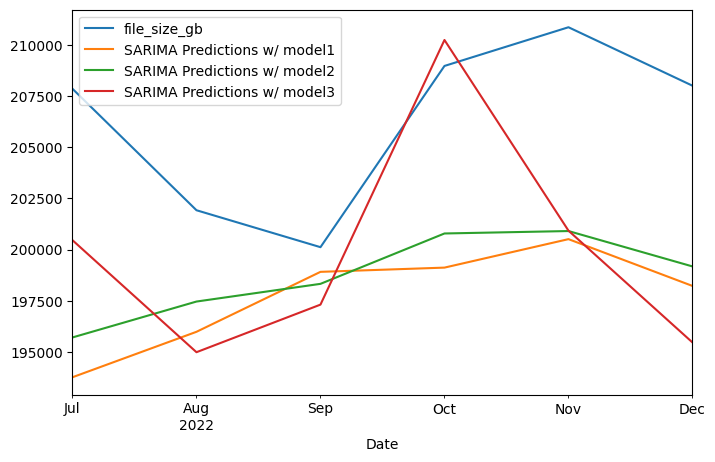

In [246]:
test['file_size_gb'].plot(figsize=(8,5), legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions3.plot(legend=True)

# 3-6) Evaluate models using MAPE, WMAPE

In [247]:
print('[MODEL1]',
      'RMSE : ',rmse(test['file_size_gb'], predictions1), 
      'MSLE : ',mean_squared_log_error(test['file_size_gb'], predictions1), 
      'MAPE : ',np.mean(np.abs((test['file_size_gb'] - predictions1)/test['file_size_gb']))*100)

print('[MODEL2]',
      'RMSE : ',rmse(test['file_size_gb'], predictions2), 
      'MSLE : ',mean_squared_log_error(test['file_size_gb'], predictions2), 
      'MAPE : ',np.mean(np.abs((test['file_size_gb'] - predictions2)/test['file_size_gb']))*100)

print('[MODEL3]',
      'RMSE : ',rmse(test['DES12_mul'], predictions3), 
      'MSLE : ',mean_squared_log_error(test['DES12_mul'], predictions3), 
      'MAPE : ',np.mean(np.abs((test['DES12_mul'] - predictions3)/test['DES12_mul']))*100)


print('[MAPE]')
print(mean_absolute_percentage_error(test['file_size_gb'], predictions1)*100)
print(mean_absolute_percentage_error(test['file_size_gb'], predictions2)*100)
print(mean_absolute_percentage_error(test['DES12_mul'], predictions3)*100)

print('[WMAPE]')
print(sum(abs(test['file_size_gb'] - predictions1)) / sum(abs(test['file_size_gb']))*100)
print(sum(abs(test['file_size_gb'] - predictions2)) / sum(abs(test['file_size_gb']))*100)
print(sum(abs(test['DES12_mul'] - predictions3)) / sum(abs(test['DES12_mul']))*100)

[MODEL1] RMSE :  9444.45513351142 MSLE :  0.0021735990505122177 MAPE :  4.108103978110083
[MODEL2] RMSE :  8313.82820855898 MSLE :  0.0016704100948807582 MAPE :  3.638423211271382
[MODEL3] RMSE :  7530.91143707422 MSLE :  0.0013480948625109407 MAPE :  3.4197359790820463
[MAPE]
4.108103978110083
3.638423211271382
3.4197359790820463
[WMAPE]
4.138180083495154
3.6653804120213365
3.4404766439765395


# 3-7) Predict 'file_size_gb' in Jan 2023

In [248]:
model = SARIMAX(train['file_size_gb'], order=(2,1,0), seasonal_order=(0,0,2,12))
results = model.fit()
fcast = results.predict(start=len(df), end=len(df)+12, typ='levels').rename('SARIMA Forecast')
fcast

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03788D+01    |proj g|=  2.05761D-01

At iterate    5    f=  1.02319D+01    |proj g|=  9.92024D-02

At iterate   10    f=  1.02254D+01    |proj g|=  1.16085D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   1.161D-05   1.023D+01
  F =   10.225442859414246     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


2023-01-01    196861.564218
2023-02-01    194991.736684
2023-03-01    203542.647380
2023-04-01    201690.548788
2023-05-01    205094.077617
2023-06-01    200782.916742
2023-07-01    201824.984474
2023-08-01    202383.438333
2023-09-01    203584.200142
2023-10-01    203992.640780
2023-11-01    204735.397322
2023-12-01    203599.573571
2024-01-01    203230.010353
Freq: MS, Name: SARIMA Forecast, dtype: float64

<Axes: xlabel='Date'>

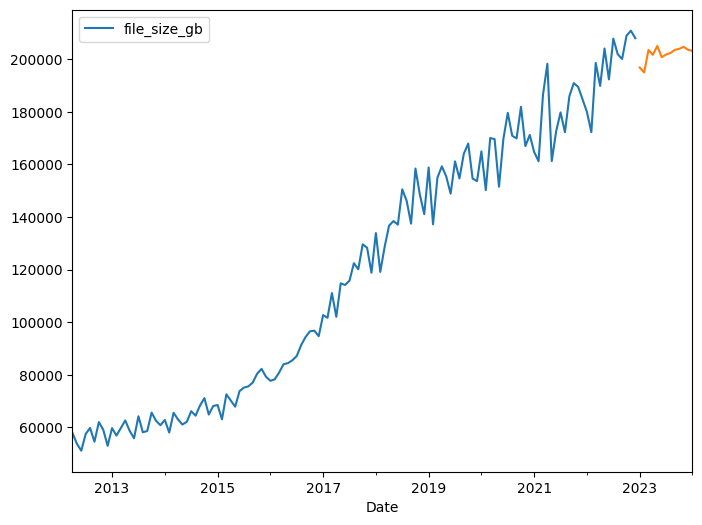

In [249]:
df['file_size_gb'].plot(figsize=(8,6), legend=True)
fcast.plot()

In [250]:
model = SARIMAX(train['DES12_mul'], order=(0,1,0), seasonal_order=(0,1,0,12))
results = model.fit()
fcast = results.predict(start=len(df), end=len(df)+12, typ='levels').rename('SARIMA Forecast')
fcast

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02610D+00    |proj g|=  5.86544D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      5      1     0     0   5.238D-06   8.023D+00
  F =   8.0232353593946790     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


2023-01-01    202237.124085
2023-02-01    191058.529192
2023-03-01    205047.135973
2023-04-01    206990.292891
2023-05-01    200162.655324
2023-06-01    207454.774551
2023-07-01    216643.650812
2023-08-01    211172.041693
2023-09-01    213496.903005
2023-10-01    226424.725338
2023-11-01    217109.914452
2023-12-01    211648.632176
2024-01-01    218419.146591
Freq: MS, Name: SARIMA Forecast, dtype: float64

<Axes: xlabel='Date'>

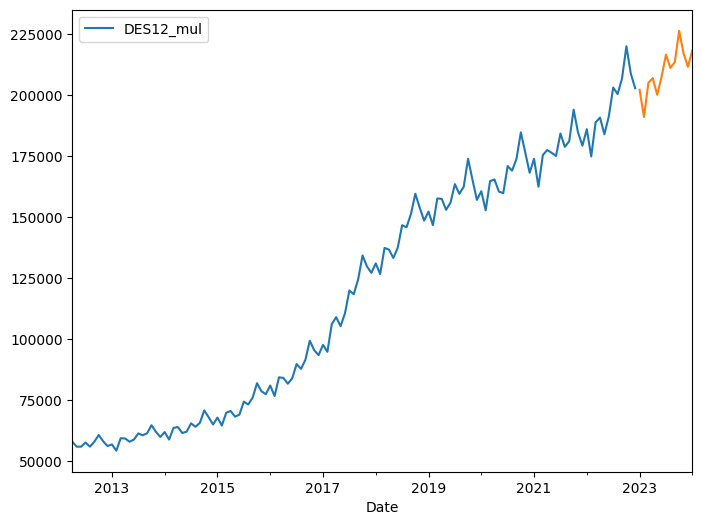

In [251]:
df['DES12_mul'].plot(figsize=(8,6), legend=True)
fcast.plot()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02610D+00    |proj g|=  5.86544D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      5      1     0     0   5.238D-06   8.023D+00
  F =   8.0232353593946790     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<Axes: xlabel='Date'>

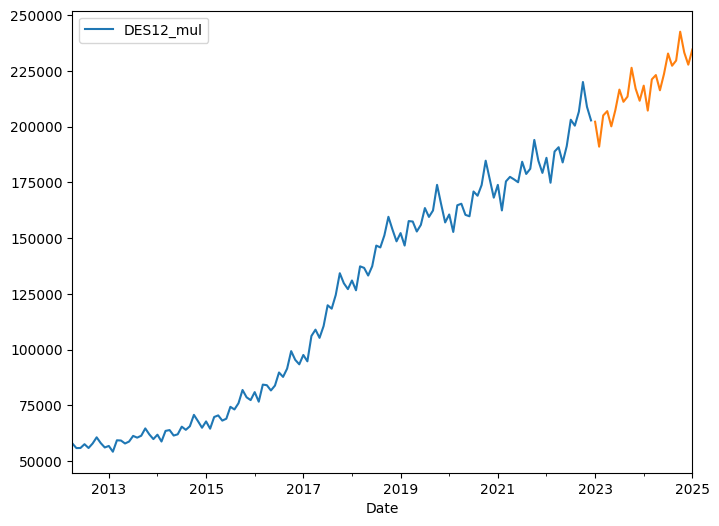

In [252]:
model = SARIMAX(train['DES12_mul'], order=(0,1,0), seasonal_order=(0,1,0,12))
results = model.fit()
fcast = results.predict(start=len(df), end=len(df)+24, typ='levels').rename('SARIMA Forecast')
df['DES12_mul'].plot(figsize=(8,6), legend=True)
fcast.plot()